# Applied Machine Learning (2021), exercises


## General instructions for all exercises

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Follow the instructions and fill in your solution under the line marked by tag

> YOUR CODE HERE

Do not change other areas of the document, since it may disturb the autograding of your results!
  
Having written the answer, execute the code cell by and pressing `Shift-Enter` key combination. The code is run, and it may print some information under the code cell. The focus automatically moves to the next cell and you may "execute" that cell by pressing `Shift-Enter` again, until you have reached the code cell which tests your solution. Execute that and follow the feedback. Usually it either says that the solution seems acceptable, or reports some errors. You can go back to your solution, modify it and repeat everything until you are satisfied. Then proceed to the next task.
   
Repeat the process for all tasks.

The notebook may also contain manually graded answers. Write your manualle graded answer under the line marked by tag:

> YOUR ANSWER HERE

Manually graded tasks may be text, pseudocode, or mathematical formulas. You can write formulas with $\LaTeX$-syntax by enclosing the formula with dollar signs (`$`), for example `$f(x)=2 \pi / \alpha$`, will produce $f(x)=2 \pi / \alpha$

When you have passed the tests in the notebook, and you are ready to submit your solutions, download the whole notebook, using menu `File -> Download as -> Notebook (.ipynb)`. Save the file in your hard disk, and submit it in [Moodle](https://moodle.uwasa.fi) under the corresponding excercise.

Your solution should be an executable Python code. Use the code already existing as an example of Python programing and read more from the numerous Python programming material from the Internet if necessary. 


In [1]:
NAME = "LEON DARIO CORREA RAMIREZ"
Student_number = "e122676"

---

# Classification exercises


## Satellite image classification

Following satellite image is obtained from the Söderfjärden meteorite crater near Vaasa at 10:00 in 28.9.2019. The image is acquired from European Sentinell 2 satellite by means of multispectral imaging device (MSI). The multispectral camera has acquired the image using 13 different wavelength bands instead of three (RGB) in the normal camera. The image was searched and dowloaded using [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/), and preprosessed by using ESA's [SNAP](http://step.esa.int/main/download/) tool.


The bands used are 

| Band number | Band name | Wavelength | Region | Remarks |
| ----------- | --------- | -----------| ------ | ------- |
|  1 | B1  |   443 nm | Violet     | Chlorophyll-A |
|  2 | B2  |   490 nm | Cyan       | |
|  3 | B3  |   560 nm | Green      | |
|  4 | B4  |   665 nm | Red        | Chlorophyll_A |
|  5 | B5  |   705 nm | Red        | |
|  6 | B6  |   740 nm | Red        | |
|  7 | B7  |   783 nm | Deep red   | |
|  8 | B8  |   842 nm | NIR        | |
|  9 | B8A |   865 nm | NIR        | |
| 10 | B9  |   945 nm | NIR        | |
| 11 | B10 |  1375 nm | NIR        | |
| 12 | B11 |  1610 nm | NIR        | |
| 13 | B12 |  2190 nm | NIR        | |

The channels listed above can be used for creating a natural looking RGB-image, as shown below.

![machine_learning.svg](Soderfjarden_image.png)

Even though, only three channels are used for RGB image, all 13 can be usefull features for land type and crops classification. 

## Training data 

In the image above, an expert has manually segmented some areas of the image and labelled them according to land use. The labelled areas are:

| Segment no. | Segment name | Segment color | 
| ----------- | --------- | -----------| 
|  1 | Water      | Violet |
|  2 | Forest     | Green |
|  3 | HayField   | Red |
|  4 | StrawField | Light Green |
|  5 | DarkSoil   | Blue |


## Task 1


### Read the data
Open the training data, which contains the pixel values of the segmented regions shown in the image above. Each pixel contains 13 floating point values between 0 and 1, one for each channel.

The training data is stored in a HDF5 file `Soderfjarden_training_data.h5`, in the subdirectory called as `data`. The file includes the following data sets:

 - `spectra`: a matrix, which dimensions are (23754, 15). Notice that two first values are the x and y coordinates of the pixel. Do not use them for classification, but use only following 13 channels. Construct a design matrix X (23754,13) by slicing this data.
 - `labels`: The expert segmented labels (23754, 1), the true values, the ground truth. This is the y-vector which you try to predict
 - `columns`: The name of the columns (15,1), if you need them. Contains the band names, shown in he table above, plus the name of the x and y coordinate columns.
 - `wavelengths`: The wavelengts of each band (13,1), the same shown in the table above.
 - The HDF5 includes also a data attribute called `timestamp`, which contains the time when the image was acquired.

The opening of the HDF5-file, and accessing the dataset can be achieved like this:

`fid = h5py.File(<filename>)
 X=fid['spectra'][:,2:]
 y_b=fid['labels'][:]
 ...
 `
 
 Use also the following line of code to decode the bytestrings obtained from HDF5 to utf8 strings (This is irritating, but necessary ). Repeat the same for decoding the column names to utf8.
 
 `y=np.array([label.decode('utf8') for label in y_b])`


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import h5py
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [3]:
#Opening file
fid = h5py.File('Soderfjarden_training_data.h5')
X=fid['spectra'][:,2:]

y_b=fid['labels'][:]
y=np.array([label.decode('utf8') for label in y_b])

cols = fid['columns'][:]
colnames = np.array([column.decode('utf8') for column in cols])

wl = fid['wavelengths'][:]

#Study the data
print('Spectra:\n',X)
print()
print('Labels:\n',y)
print()
print('Columns:\n',colnames)
print()
print('Wavelengths:\n',wl)

Spectra:
 [[0.1619 0.1301 0.1148 ... 0.0036 0.2143 0.125 ]
 [0.1619 0.1386 0.1169 ... 0.0036 0.1735 0.1227]
 [0.1619 0.1397 0.1183 ... 0.0036 0.1735 0.1227]
 ...
 [0.1619 0.1524 0.1463 ... 0.003  0.3342 0.2055]
 [0.1619 0.1503 0.1475 ... 0.003  0.3342 0.2055]
 [0.1619 0.155  0.1531 ... 0.003  0.3478 0.2129]]

Labels:
 ['DarkSoil' 'DarkSoil' 'DarkSoil' ... 'StrawField' 'StrawField'
 'StrawField']

Columns:
 ['Pixel-X' 'Pixel-Y' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B8A' 'B9'
 'B10' 'B11' 'B12' 'Type']

Wavelengths:
 [ 945.  865.  842.  783.  740.  705.  665.  560.  490.  443. 2190. 1610.
 1375.]


<ipython-input-3-88690e659b4f>:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  fid = h5py.File('Soderfjarden_training_data.h5')


In [4]:
assert(X.shape==(23754,13))
assert(y.shape==(23754,))
assert(colnames.shape==(16,))
assert(y.dtype=='<U10')

## Task 2

Analyze the complexity of the data  by plotting it with two first principal components

 - Transform the the data in PCA domain as `pc`
 - Transform the y-vector to integer vector `yi`, using for example LabelEncoder
 - Plot a scatter plot of two first principal components, where the color is `yi`, the integer representation of `y` (=classes)

Categories:
 Index(['DarkSoil', 'Forest', 'HayField', 'StrawField', 'Water'], dtype='object')

DarkSoil : 0 -->represented as PURPLE
Forest : 1 -->represented as CYAN
HayField : 2 -->represented as GREEN
StrawField : 3 -->represented as ORANGE
Water : 4 -->represented as RED

Original y:
 ['DarkSoil' 'DarkSoil' 'DarkSoil' ... 'StrawField' 'StrawField'
 'StrawField']

Transformed yi with LabelEncoder:
 [0 0 0 ... 3 3 3]


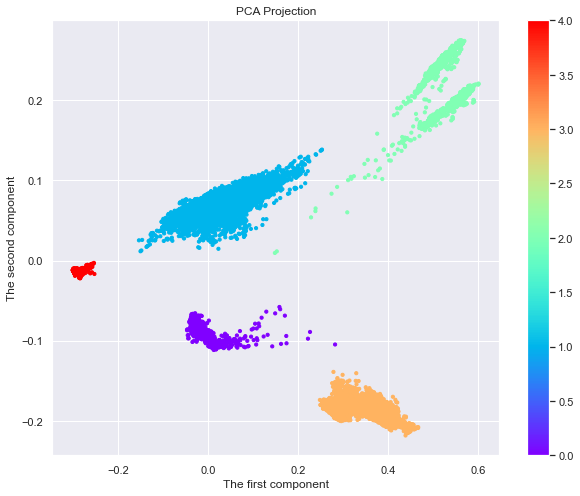

In [5]:
#Import Label Encoder and PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Dataframe Creation
df = pd.DataFrame(X)
df.head()

# Transform df to PCA domain
pca = PCA(n_components=2)
pc = pca.fit_transform(df)

# Normalize the data by using labelEncoder
le = LabelEncoder()
le.fit(y)

# Categories for study purposes 
dfy = pd.DataFrame(y)
types = pd.Categorical(dfy.iloc[:,0])
print('Categories:\n',types.categories)
print()
print(types[0],":", types.codes[700], "-->represented as PURPLE")
print(types[2000],":", types.codes[2000], "-->represented as CYAN")
print(types[19000],":", types.codes[19000], "-->represented as GREEN")
print(types[22000],":", types.codes[22000], "-->represented as ORANGE")
print(types[10000],":", types.codes[10000], "-->represented as RED")
print()

# Transform the string values of y to numerical data and store it in yi
yi = le.transform(y)
print('Original y:\n',y)
print()
print('Transformed yi with LabelEncoder:\n',yi)

# Ploting of PCA projection of the two first components
sns.set()
plt.figure(figsize=(10,8))
plt.scatter(pc[:, 0], pc[:, 1],c=yi, alpha=1, cmap='rainbow', s=10)
plt.title('PCA Projection')
plt.xlabel('The first component')
plt.ylabel('The second component')
plt.colorbar()

In [6]:
assert(pc.shape==(23754, 2)), "Something is wrong with PCA"
assert((max(yi)-min(yi))==4), "Something is wrong with integer labels"


## Task 3

- Create a processing pipeline using standard scaler and some classification method, name the pipeline as `predictor`
- Train the pipeline and check if it passes the tests for precision in training set
- Separate your data X and y to training set (X_train, y_train) which contains 75% of the data and to the test set X_test, y_test which contains 25% of the data. Use function `train_test_split` from library `sklearn.model_selection`.

Training Score: 1.0
Test Score: 0.999663242970197


[Text(223.20000000000002, 587.0880000000001, 'X[5] <= 0.075\ngini = 0.713\nsamples = 17815\nvalue = [1086, 6370, 1204, 2845, 6310]'),
 Text(111.60000000000001, 456.624, 'gini = 0.0\nsamples = 6310\nvalue = [0, 0, 0, 0, 6310]'),
 Text(334.8, 456.624, 'X[11] <= 0.126\ngini = 0.612\nsamples = 11505\nvalue = [1086, 6370, 1204, 2845, 0]'),
 Text(223.20000000000002, 326.1600000000001, 'gini = 0.0\nsamples = 6370\nvalue = [0, 6370, 0, 0, 0]'),
 Text(446.40000000000003, 326.1600000000001, 'X[12] <= 0.161\ngini = 0.593\nsamples = 5135\nvalue = [1086, 0, 1204, 2845, 0]'),
 Text(334.8, 195.69600000000003, 'X[7] <= 0.248\ngini = 0.499\nsamples = 2290\nvalue = [1086, 0, 1204, 0, 0]'),
 Text(223.20000000000002, 65.23200000000008, 'gini = 0.0\nsamples = 1086\nvalue = [1086, 0, 0, 0, 0]'),
 Text(446.40000000000003, 65.23200000000008, 'gini = 0.0\nsamples = 1204\nvalue = [0, 0, 1204, 0, 0]'),
 Text(558.0, 195.69600000000003, 'gini = 0.0\nsamples = 2845\nvalue = [0, 0, 0, 2845, 0]')]

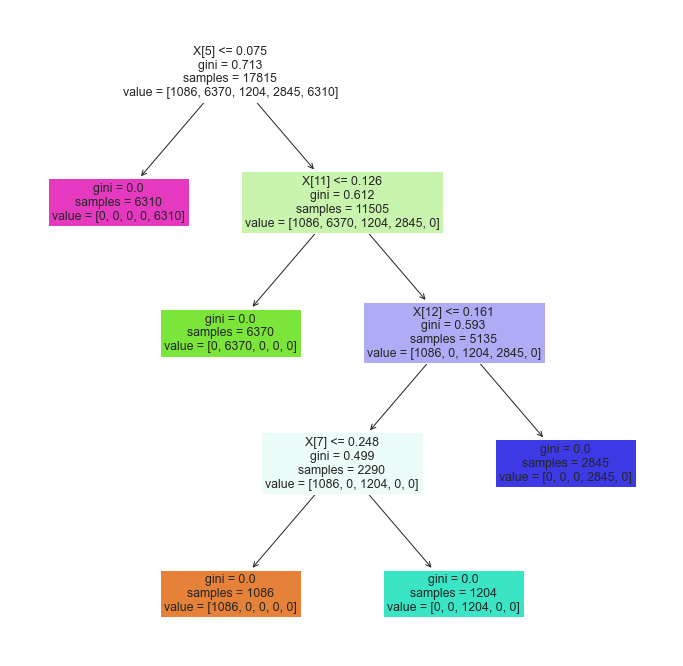

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn import neighbors
import sklearn.metrics as metrics

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,yi, test_size=0.25)

# Pipeline using KNN
#predictor = Pipeline([
#        ('Scaling', StandardScaler()),
#        ('KNN', neighbors.KNeighborsClassifier(2))
#    ])
#predictor.fit(X_train,y_train)
#yh=predictor.predict(X_test)
#print(metrics.confusion_matrix(y_true=y_test y_pred=yh))
#print(metrics.accuracy_score(y_true=y_test, y_pred=yh))

# Pipeline using Decision Tree
sdepth = 4
predictor = Pipeline([
       ('Scaling', StandardScaler()),
       ('DecisionTree', tree.DecisionTreeClassifier(max_depth=sdepth))
         ])
predictor.fit(X_train,y_train)

# Metrics
print("Training Score:",metrics.accuracy_score(y_true=y_train, y_pred=predictor.predict(X_train)))

# Testing of the model
yh_test=predictor.predict(X_test)
test_score=metrics.accuracy_score(y_true=y_test, y_pred=yh_test) 

print('Test Score:',test_score)

# For visualization purposes
plt.figure(figsize=(12,12))
tree.plot_tree(DecisionTreeClassifier().fit(X_train,y_train),filled=True)

In [8]:
# Testing the precision in the training set
yh=predictor.predict(X_train)
train_score=metrics.accuracy_score(y_true=y_train, y_pred=yh)
if len(predictor.steps)<2:
    print("The predictor is not a pipeline. Did you forget scaling?")
assert(len(predictor.steps)>=2)
assert(test_score > 0.95)


In [9]:
print(train_score)

1.0


## Task 4: Evaluation of the predictor

Having trained the predictor, evaluate now it's performance using cross validation and test set. You may use `cross_val_score` function from the `sklearn.model_selection` library and `accuracy_score` from the `sklearn.metrics` library.

Print also the confusion matrix to see which areas are miss-classified. Use `confusion_matrix` function from the `sklearn.metrics` library


For the Decision tree classifier with Depth of 4 the scores are:

Mean CV Score: 0.9999438675273644
Train Score: 1.0
Test Score: 0.999663242970197

Confusion Matrix:
 [[ 359    0    1    1    0]
 [   0 2121    0    0    0]
 [   0    0  356    0    0]
 [   0    0    0 1005    0]
 [   0    0    0    0 2096]]


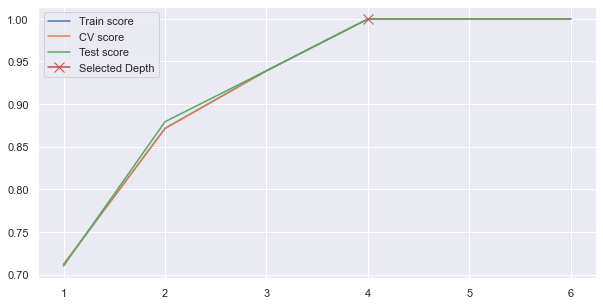

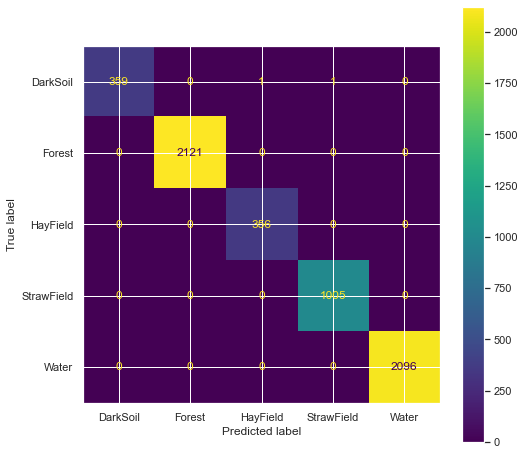

In [10]:
from sklearn.model_selection import cross_val_score

# Study the scores of the classifier
N=6
Atrain_score=np.zeros(N)
Atest_score=np.zeros(N)
Acv_score=np.zeros(N)
Adepth=np.arange(N)+1
for i in range(N):
    dt = tree.DecisionTreeClassifier(max_depth=Adepth[i])
    dt.fit(X_train, y_train)
    Atrain_score[i]=metrics.accuracy_score(y_train, dt.predict(X_train))
    Atest_score[i]=metrics.accuracy_score(y_test, dt.predict(X_test))
    Acv_score[i] = cross_val_score(dt, X_train, y_train, cv=5).mean()
plt.figure(figsize=(10,5))    
plt.plot(Adepth, Atrain_score, label="Train score")
plt.plot(Adepth, Acv_score, label="CV score")
plt.plot(Adepth, Atest_score, label="Test score")
plt.plot(sdepth,1, marker='x', markersize=10, label="Selected Depth")
plt.legend()


# Predictor scores assessment
cv_score = cross_val_score(predictor, X_train, y_train, cv=5).mean()
train_score = metrics.accuracy_score(y_train, predictor.predict(X_train)) 
test_score = metrics.accuracy_score(y_test, predictor.predict(X_test))

print('For the Decision tree classifier with Depth of 4 the scores are:')
print()
print('Mean CV Score:',cv_score)
print('Train Score:',train_score)
print('Test Score:',test_score)
print()

# Print Confussion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

labels = types.categories
cm = metrics.confusion_matrix(y_true=y_test, y_pred=yh_test)
print('Confusion Matrix:\n',cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8,8))
cmd.plot(ax=ax)

In [11]:
assert(cv_score > 0.95)
assert(train_score > 0.95)
assert(test_score > 0.95)

## Task 5: Interpretation of the results

1. What is your opinion of the precision you achieved?
1. Can you see signs of overfitting? Why/Why not?
1. Which samples were misclassified? To which class they were assigned?


ANSWERS
1. The precision that was obtained is extremely high due to the data to be clearly distinguishable as seen from the PCA projection in which the clusred obtained are clearly separated.
2. The model shows low training error as the score for it is extremely high, which might hint overfitting, however, 
    the model also shows low test error and the cross validation score in average is also extremely high, therefore the model fitting is optimum
3. According to the confussion matrix, only 2 samples were missclasified using the decision tree classifier, these samples were assigned to the "DarkSoil" class and they should have been assigned to "HayField" and "StrawField" respectively.